# Lego robot trainer

Hello. This is the file that contains the code for training the lego sorting model.
Most of the code here is based off the tutorial by Google (2021).

First, all the required libraries are imported.

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [46]:
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

Lets create some configuration variables for loading images.

In [47]:
data_set_path = './data'
data_set_list = glob.glob(os.path.join(data_set_path, '*/*.png'))
data_set_size = len(data_set_list)

IMG_SIZE = (160, 160)

And to prove it works, we will load 8 random imaegs from our dataset.

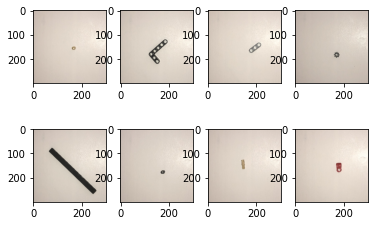

In [48]:
# Code based on Vasant Vohra (2019)

for i, path in enumerate(random.sample(data_set_list, 8)):
    img = image.img_to_array(image.load_img(path, target_size=(300, 300)), dtype=np.uint8)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img.squeeze())

Now we need to seperate our data set into training and validation sets. 

In [49]:
# Based on apatsekin (2018)

data_set = image_dataset_from_directory(data_set_path,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=IMG_SIZE)

data_set_size = len(data_set)

training_dataset = data_set.take(int(0.9 * data_set_size))
validation_dataset = data_set.skip(int(0.1 * data_set_size))

Found 222 files belonging to 6 classes.


Now, lets split the validation into test and validation datasets.   

In [50]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print(len(validation_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

6
Number of validation batches: 6
Number of test batches: 1


In [73]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])


def prepare(ds, shuffle=False, augment=True):
  # Resize and rescale all datasets
  # ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
  #             num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)


train_dataset = prepare(training_dataset)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

ValueError: in user code:

    /var/folders/05/0_sj57ls4s10jxqxp2d5cvqw0000gp/T/ipykernel_67993/238859817.py:17 None  *
        lambda x, y: (resize_and_rescale(x), y)
    /usr/local/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.9/site-packages/keras/engine/sequential.py:383 call
        outputs = layer(inputs, **kwargs)
    /usr/local/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.9/site-packages/keras/layers/preprocessing/image_preprocessing.py:99 call
        outputs = tf.image.resize(
    /usr/local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/ops/image_ops_impl.py:1717 resize_images_v2
        return _resize_images_common(
    /usr/local/lib/python3.9/site-packages/tensorflow/python/ops/image_ops_impl.py:1405 _resize_images_common
        raise ValueError('\'size\' must be a 1-D Tensor of 2 elements: '

    ValueError: 'size' must be a 1-D Tensor of 2 elements: new_height, new_width


Now we need to rescale the images so rather than values between 0 and 255, we can use values between -1 and 1.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False

(32, 5, 5, 1280)


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [ ]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 [==============================] - 7s 546ms/step - loss: -8.9337 - accuracy: 0.2684


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -8.93
initial accuracy: 0.27


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
6/6 [==============================] - 12s 2s/step - loss: -10.1050 - accuracy: 0.2760 - val_loss: -9.5425 - val_accuracy: 0.2737
Epoch 2/30
6/6 [==============================] - 12s 2s/step - loss: -10.5189 - accuracy: 0.2917 - val_loss: -10.5328 - val_accuracy: 0.2632
Epoch 3/30
6/6 [==============================] - 12s 2s/step - loss: -11.6650 - accuracy: 0.2656 - val_loss: -10.5050 - val_accuracy: 0.2789
Epoch 4/30
6/6 [==============================] - 11s 2s/step - loss: -11.8571 - accuracy: 0.2656 - val_loss: -11.4497 - val_accuracy: 0.2526
Epoch 5/30
6/6 [==============================] - 11s 2s/step - loss: -11.8430 - accuracy: 0.2917 - val_loss: -11.8703 - val_accuracy: 0.2579
Epoch 6/30
6/6 [==============================] - 11s 2s/step - loss: -13.6956 - accuracy: 0.2500 - val_loss: -12.4359 - val_accuracy: 0.2579
Epoch 7/30
6/6 [==============================] - 15s 2s/step - loss: -13.0626 - accuracy: 0.2604 - val_loss: -12.3212 - val_accuracy: 0.2947
Epoch 8

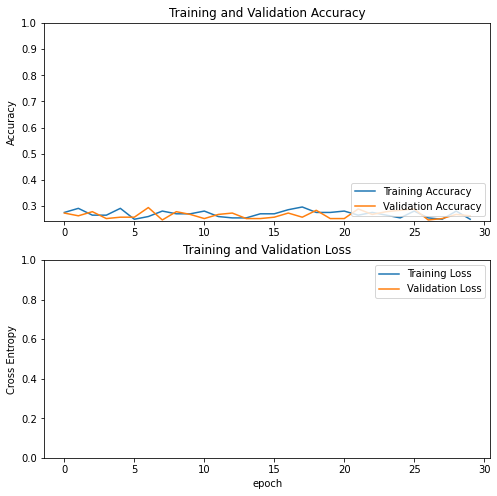

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Sources
The information used to create this project is from the following sources. This
doesn't folow Harvard referencing style.
1. Google (2021) [Transfer learning & fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning), accessed on 24 Augest 2021.
2. Vasant Vohra (2019) [Transfer Learning using MobileNet](https://www.kaggle.com/vasantvohra1/transfer-learning-using-mobilenet), accessed on 24 Augest 2021.
3. Dmytro Prylipko (2019) [tf.data.Dataset from tf.keras.preprocessing.image.ImageDataGenerator.flow_from_directory?](https://stackoverflow.com/questions/54606302/tf-data-dataset-from-tf-keras-preprocessing-image-imagedatagenerator-flow-from-d), accessed on 24 Augest 2021.
4. apatsekin (2018) [Split a dataset created by Tensorflow dataset API in to Train and Test?](https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test), accessed on 24 Augest 2021.